In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import gc
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve

In [144]:
pd.set_option('display.max_columns', None)
url="https://media.githubusercontent.com/media/divija-rao/MBS_RiskManagement/refs/heads/divi_trees/extracted_data/regression_data.csv"

In [146]:
chunksize = 100000
chunks = []

for chunk in pd.read_csv("https://media.githubusercontent.com/media/divija-rao/MBS_RiskManagement/refs/heads/divi_trees/extracted_data/regression_data.csv", chunksize=chunksize):
    chunks.append(chunk)  # optionally process each chunk here
df = pd.concat(chunks)

In [147]:
url = "https://media.githubusercontent.com/media/divija-rao/MBS_RiskManagement/refs/heads/divi_trees/extracted_data/regression_data.csv"
output_path = Path("enriched_sample_3M.parquet")
desired_total = 3_000_000
seed = 42
chunksize = 200_000    # reduce if memory/time is an issue
# -----------------------------------

random.seed(seed)
np.random.seed(seed)

# PASS 1: count defaults (fast: read just the Default column)
print("PASS 1: counting defaults...")
total_rows = 0
total_defaults = 0
for chunk in pd.read_csv(url, usecols=["Default"], chunksize=chunksize):
    vc = chunk["Default"].value_counts()
    total_rows += len(chunk)
    total_defaults += int(vc.get(1, 0))
print(f"Total rows = {total_rows:,}; Total defaults = {total_defaults:,}")

if total_defaults == 0:
    raise SystemExit("No defaults found — aborting.")

# Decide targets
pos_target = min(total_defaults, desired_total - 1)  # include up to all defaults, but leave >=1 negative
neg_target = desired_total - pos_target
print(f"Target positives: {pos_target:,}; Target negatives: {neg_target:,} (final {desired_total:,})")

# PASS 2: stream to collect positives and reservoir-sample negatives
print("PASS 2: streaming to collect rows...")
positives = []
neg_reservoir = []
neg_seen = 0

# Read full set of columns from CSV header
header = pd.read_csv(url, nrows=0).columns.tolist()
print("Detected columns:", header)

for chunk in pd.read_csv(url, chunksize=chunksize):
    # convert chunk to list of records (faster iteration)
    records = chunk.to_dict(orient="records")
    for rec in records:
        # robustly parse target (handles ints, floats, strings)
        try:
            cls = int(rec.get("Default", 0))
        except Exception:
            cls = int(float(rec.get("Default", 0) or 0))
        if cls == 1:
            if len(positives) < pos_target:
                positives.append(rec)
        else:
            neg_seen += 1
            if len(neg_reservoir) < neg_target:
                neg_reservoir.append(rec)
            else:
                j = random.randrange(neg_seen)
                if j < neg_target:
                    neg_reservoir[j] = rec
    # free memory for chunk
    del chunk, records
    gc.collect()

print(f"Collected positives = {len(positives):,}; negatives sampled = {len(neg_reservoir):,}")
if len(positives) + len(neg_reservoir) < desired_total:
    print("WARNING: final sample smaller than desired_total — proceeding with what we have.")

# Combine and shuffle
combined = positives + neg_reservoir
random.shuffle(combined)

# Convert to DataFrame and downcast types to save memory/disk
sample_df = pd.DataFrame(combined)
print("Sample DF shape:", sample_df.shape)
print("Basic memory/info before downcast:")
print(sample_df.info(memory_usage="deep"))

# Downcast numeric types
for col in sample_df.select_dtypes(include=["float64"]).columns:
    sample_df[col] = pd.to_numeric(sample_df[col], downcast="float")
for col in sample_df.select_dtypes(include=["int64"]).columns:
    sample_df[col] = pd.to_numeric(sample_df[col], downcast="integer")

# Convert low-cardinality object columns to category
for col in sample_df.select_dtypes(include=["object"]).columns:
    if sample_df[col].nunique(dropna=True) / len(sample_df) < 0.5:
        sample_df[col] = sample_df[col].astype("category")

print("After downcast:")
print(sample_df.info(memory_usage="deep"))
print("Default value counts in sample:")
print(sample_df["Default"].value_counts(dropna=False))

# Save to Parquet
print(f"Saving sample to {output_path} ...")
sample_df.to_parquet(output_path, index=False, compression="snappy")
print("Saved.")

# cleanup
del positives, neg_reservoir, combined, sample_df
gc.collect()
print("Done. Load with pd.read_parquet('enriched_sample_3M.parquet')")

PASS 1: counting defaults...
Total rows = 20,323,122; Total defaults = 210,382
Target positives: 210,382; Target negatives: 2,789,618 (final 3,000,000)
PASS 2: streaming to collect rows...
Detected columns: ['Loan Sequence Number', 'Credit Score', 'Occupancy Status', 'Original Combined Loan-to-Value (CLTV)', 'Original Debt-to-Income (DTI) Ratio', 'Original UPB', 'Original Loan-to-Value (LTV)', 'Original Interest Rate', 'Property State', 'Original Loan Term', 'Number of Borrowers', 'Current Actual UPB', 'Current Loan Delinquency Status', 'Loan Age', 'Remaining Months to Legal Maturity', 'Current Interest Rate', 'Current Deferred UPB', 'Estimated Loan-to-Value (ELTV)', 'Default']
Collected positives = 210,382; negatives sampled = 2,789,618
Sample DF shape: (3000000, 19)
Basic memory/info before downcast:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column                                  Dtype  
---  ------         

In [148]:
df1= pd.read_parquet("enriched_sample_3M.parquet")

In [149]:
df1.head()

,Loan Sequence Number,Credit Score,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Property State,Original Loan Term,Number of Borrowers,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Current Deferred UPB,Estimated Loan-to-Value (ELTV),Default
0,F21Q20929001,667.0,P,90.0,45.0,392000.0,90.0,4.000,NJ,360.0,2.0,407000.00,4.0,6.0,474.0,4.000,0.0,66.0,1
1,F14Q30167553,760.0,P,75.0,35.0,590000.0,75.0,3.500,CA,180.0,1.0,0.00,0.0,82.0,98.0,3.500,0.0,999.0,0
2,F16Q20366527,766.0,P,45.0,50.0,255000.0,45.0,3.625,CO,360.0,2.0,0.00,0.0,18.0,342.0,3.625,0.0,999.0,0
3,F21Q20037999,713.0,P,80.0,36.0,222000.0,80.0,3.375,NH,360.0,1.0,204434.59,1.0,46.0,314.0,3.375,0.0,48.0,1
4,F20Q20685349,769.0,P,78.0,24.0,110000.0,78.0,3.500,NC,360.0,2.0,98739.63,0.0,56.0,304.0,3.500,0.0,47.0,0


In [150]:
df1.shape

(3000000, 19)

In [151]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 19 columns):
 #   Column                                  Dtype   
---  ------                                  -----   
 0   Loan Sequence Number                    object  
 1   Credit Score                            float32 
 2   Occupancy Status                        category
 3   Original Combined Loan-to-Value (CLTV)  float32 
 4   Original Debt-to-Income (DTI) Ratio     float32 
 5   Original UPB                            float32 
 6   Original Loan-to-Value (LTV)            float32 
 7   Original Interest Rate                  float32 
 8   Property State                          category
 9   Original Loan Term                      float32 
 10  Number of Borrowers                     float32 
 11  Current Actual UPB                      float64 
 12  Current Loan Delinquency Status         float32 
 13  Loan Age                                float32 
 14  Remaining Months t

In [152]:
df1.describe()

,Credit Score,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Original Loan Term,Number of Borrowers,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Current Deferred UPB,Estimated Loan-to-Value (ELTV),Default
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,2.998857e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,2.917965e+06,3.000000e+06
mean,7.497620e+02,7.333801e+01,5.693322e+01,2.686329e+05,7.296017e+01,4.027982e+00,3.256514e+02,1.472238e+00,1.438205e+05,2.864001e-01,4.262432e+01,2.845718e+02,4.024579e+00,2.672703e+02,4.155265e+02,7.012733e-02
std,1.308868e+02,1.817041e+01,1.433324e+02,1.455105e+05,1.792460e+01,1.233855e+00,6.950233e+01,5.159911e-01,1.652085e+05,1.964472e+00,2.684664e+01,7.866628e+01,1.233891e+00,2.865084e+03,4.608881e+02,2.553615e-01
min,3.000000e+02,1.000000e+00,1.000000e+00,9.000000e+03,1.000000e+00,1.500000e+00,8.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e+00,1.500000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.160000e+02,6.300000e+01,2.800000e+01,1.590000e+05,6.300000e+01,3.049000e+00,3.600000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,2.670000e+02,3.000000e+00,0.000000e+00,4.400000e+01,0.000000e+00
50%,7.570000e+02,7.700000e+01,3.600000e+01,2.400000e+05,7.600000e+01,3.750000e+00,3.600000e+02,1.000000e+00,1.023224e+05,0.000000e+00,4.100000e+01,3.130000e+02,3.750000e+00,0.000000e+00,6.800000e+01,0.000000e+00
75%,7.870000e+02,8.500000e+01,4.300000e+01,3.510000e+05,8.500000e+01,4.510000e+00,3.600000e+02,2.000000e+00,2.419141e+05,0.000000e+00,5.400000e+01,3.350000e+02,4.500000e+00,0.000000e+00,9.990000e+02,0.000000e+00
max,9.999000e+03,9.990000e+02,9.990000e+02,2.000000e+06,9.990000e+02,9.500000e+00,5.480000e+02,5.000000e+00,1.965913e+06,1.160000e+02,1.340000e+02,4.840000e+02,9.500000e+00,3.750000e+05,9.990000e+02,1.000000e+00


In [153]:
df1.isnull().sum()

Loan Sequence Number                          1
Credit Score                                  0
Occupancy Status                              0
Original Combined Loan-to-Value (CLTV)        0
Original Debt-to-Income (DTI) Ratio           0
Original UPB                                  0
Original Loan-to-Value (LTV)                  0
Original Interest Rate                        0
Property State                                0
Original Loan Term                            0
Number of Borrowers                           0
Current Actual UPB                            0
Current Loan Delinquency Status            1143
Loan Age                                      0
Remaining Months to Legal Maturity            0
Current Interest Rate                         0
Current Deferred UPB                          0
Estimated Loan-to-Value (ELTV)            82035
Default                                       0
dtype: int64

In [154]:
df1[df1["Loan Sequence Number"].duplicated()]

,Loan Sequence Number,Credit Score,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,Original Loan-to-Value (LTV),Original Interest Rate,Property State,Original Loan Term,Number of Borrowers,Current Actual UPB,Current Loan Delinquency Status,Loan Age,Remaining Months to Legal Maturity,Current Interest Rate,Current Deferred UPB,Estimated Loan-to-Value (ELTV),Default


In [155]:
df1['Default'].value_counts()

Default
0    2789618
1     210382
Name: count, dtype: int64

In [156]:
print("Total records:", len(df1))
print("Total unique loans:", df1['Loan Sequence Number'].nunique())

Total records: 3000000
Total unique loans: 2999999


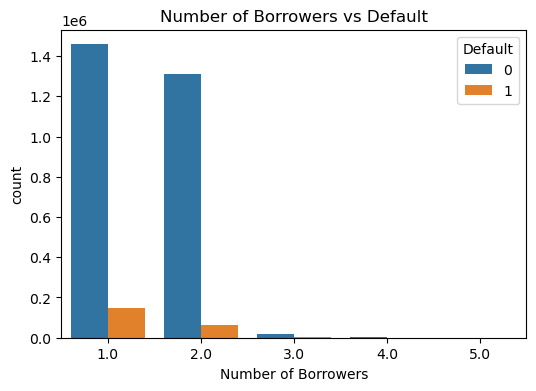

In [157]:
# Clean Number of Borrowers
df1['Number of Borrowers'] = pd.to_numeric(df1['Number of Borrowers'], errors='coerce')
df1['Number of Borrowers'] = df1['Number of Borrowers'].apply(
    lambda x: 99 if pd.isna(x) else x
)

# Number of Borrowers vs Default
plt.figure(figsize=(6, 4))
sns.countplot(x='Number of Borrowers', hue='Default', data=df1[df1['Number of Borrowers'] != 99])  # Exclude missing (99)
plt.title('Number of Borrowers vs Default')
plt.show()

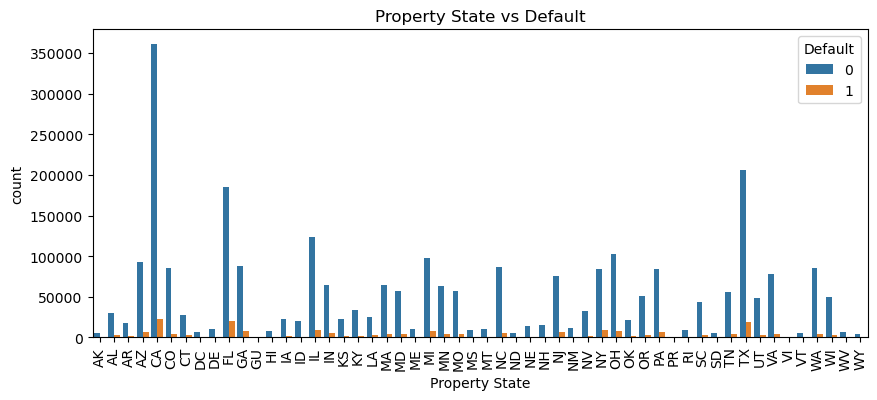

In [158]:
# Clean Property State (ensure categorical, no numeric conversion needed)
# Assuming it's already a string, no cleaning beyond ensuring valid states can be added if needed

# Property State vs Default
plt.figure(figsize=(10, 4))
sns.countplot(x='Property State', hue='Default', data=df1)
plt.title('Property State vs Default')
plt.xticks(rotation=90)
plt.show()

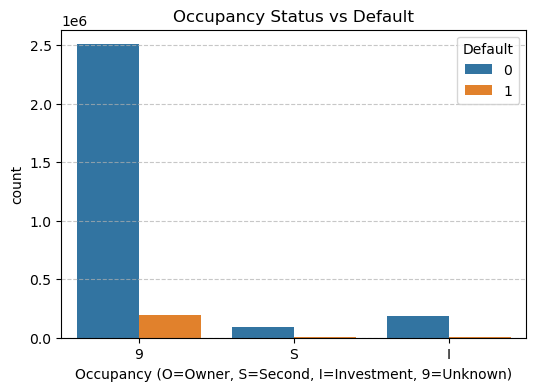

In [159]:
# Clean Occupancy Status
df1['Occupancy Status'] = df1['Occupancy Status'].astype(str).str.strip()
df1['Occupancy Status'] = df1['Occupancy Status'].apply(
    lambda x: '9' if x not in ['O', 'S', 'I'] else x
)

# Occupancy Status vs Default
plt.figure(figsize=(6, 4))
sns.countplot(x='Occupancy Status', hue='Default', data=df1)
plt.title('Occupancy Status vs Default')
plt.xlabel('Occupancy (O=Owner, S=Second, I=Investment, 9=Unknown)')

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500000))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

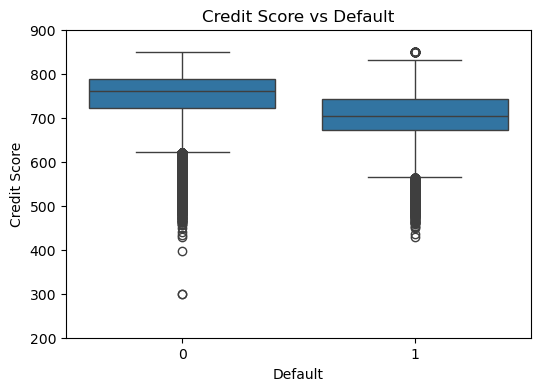

In [160]:
# Clean Credit Score based on guide notes
df1['Credit Score'] = pd.to_numeric(df1['Credit Score'], errors='coerce')
df1['Credit Score'] = df1['Credit Score'].apply(
    lambda x: 300 if x < 300 else 850 if x > 850 else 9999 if pd.isna(x) else x
)

# Credit Score vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Credit Score', data=df1)
plt.title('Credit Score vs Default')
plt.ylim(200, 900)
plt.show()

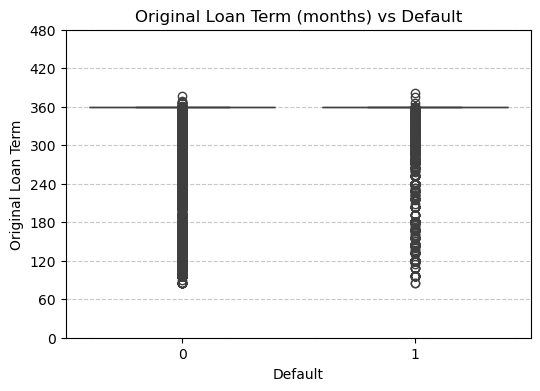

In [161]:
# Clean Original Loan Term (no capping needed, just ensure numeric)
df1['Original Loan Term'] = pd.to_numeric(df1['Original Loan Term'], errors='coerce')

# Original Loan Term vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Original Loan Term', data=df1)
plt.title('Original Loan Term (months) vs Default')
plt.ylim(0, 480)  # Reasonable upper limit (e.g., 40 years in months)
#grid yaxis to each 5 years (60 months)
plt.yticks(range(0, 481, 60), [str(i) for i in range(0, 481, 60)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

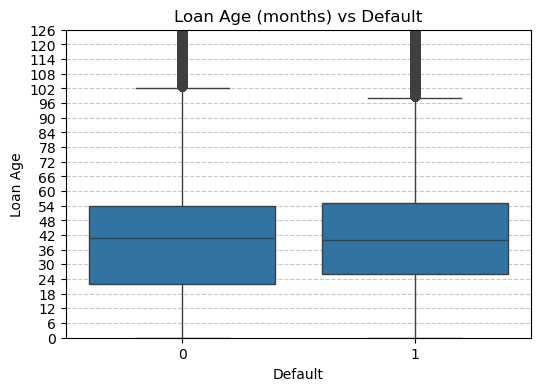

In [162]:
# Clean Loan Age
df1['Loan Age'] = pd.to_numeric(df1['Loan Age'], errors='coerce')
df1['Loan Age'] = df1['Loan Age'].apply(
    lambda x: 999 if pd.isna(x) else x
)

# Loan Age vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Loan Age', data=df1[df1['Loan Age'] != 999])  # Exclude missing (999)
plt.title('Loan Age (months) vs Default')
plt.ylim(0, 120)  #  upper limit (e.g., 10 years in months)

plt.yticks(range(0, 128, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

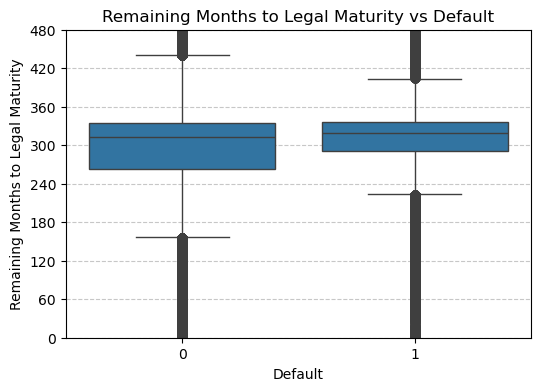

In [163]:
# Clean Remaining Months to Legal Maturity
df1['Remaining Months to Legal Maturity'] = pd.to_numeric(df1['Remaining Months to Legal Maturity'], errors='coerce')
df1['Remaining Months to Legal Maturity'] = df1['Remaining Months to Legal Maturity'].apply(
    lambda x: 999 if pd.isna(x) else x
)

# Remaining Months to Legal Maturity vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Remaining Months to Legal Maturity', data=df1[df1['Remaining Months to Legal Maturity'] != 999])  # Exclude missing (999)
plt.title('Remaining Months to Legal Maturity vs Default')
plt.ylim(0, 480)  # Reasonable upper limit (e.g., 40 years in months)

plt.yticks(range(0, 481, 60), [str(i) for i in range(0, 481, 60)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

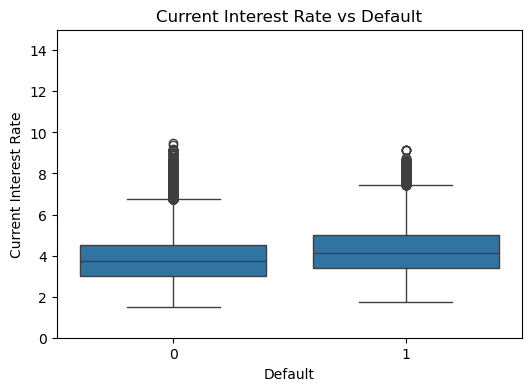

In [164]:
# Clean Current Interest Rate
df1['Current Interest Rate'] = pd.to_numeric(df1['Current Interest Rate'], errors='coerce')
df1['Current Interest Rate'] = df1['Current Interest Rate'].apply(
    lambda x: 99.999 if pd.isna(x) else x
)

# Current Interest Rate vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Current Interest Rate', data=df1[df1['Current Interest Rate'] != 99.999])  # Exclude missing (99.999)
plt.title('Current Interest Rate vs Default')
plt.ylim(0, 15)  # Reasonable upper limit (e.g., 15%)
plt.show()

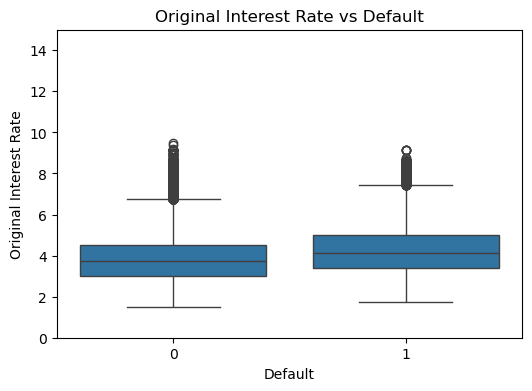

In [165]:
# Clean Original Interest Rate (no capping needed, just ensure numeric)
df1['Original Interest Rate'] = pd.to_numeric(df1['Original Interest Rate'], errors='coerce')

# Original Interest Rate vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Original Interest Rate', data=df1)
plt.title('Original Interest Rate vs Default')
plt.ylim(0, 15)  # Reasonable upper limit for interest rates (e.g., 15%)
plt.show()

In [166]:
# Clean Original Loan-to-Value (LTV)
df1['Original Loan-to-Value (LTV)'] = pd.to_numeric(df1['Original Loan-to-Value (LTV)'], errors='coerce')
df1['Original Loan-to-Value (LTV)'] = df1['Original Loan-to-Value (LTV)'].apply(
    lambda x: 999 if pd.isna(x) else x
)

ltv_values= df1[df1['Original Loan-to-Value (LTV)'] != 999]['Original Loan-to-Value (LTV)']
ltv_values.describe()

count    2.999988e+06
mean     7.295647e+01
std      1.787012e+01
min      1.000000e+00
25%      6.300000e+01
50%      7.600000e+01
75%      8.500000e+01
max      5.410000e+02
Name: Original Loan-to-Value (LTV), dtype: float64

In [167]:
# count ltv values greater than 100
print("LTV values greater than 100:", (ltv_values > 100).sum())

LTV values greater than 100: 9420


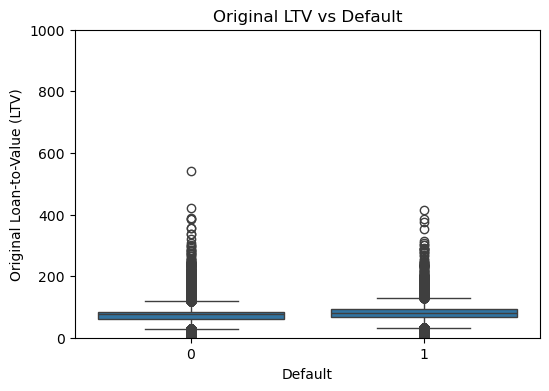

In [168]:
# Original LTV vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Original Loan-to-Value (LTV)', data= df1[df1['Original Loan-to-Value (LTV)'] != 999])  # Exclude missing
plt.ylim(0, 1000)  # Reasonable upper limit for LTV
plt.title('Original LTV vs Default')
plt.show()

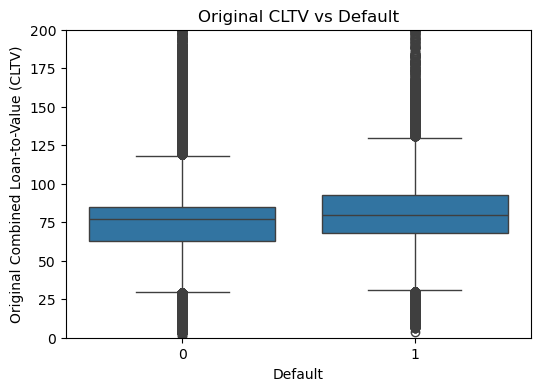

In [169]:
# Clean Original Combined Loan-to-Value (CLTV)
df1['Original Combined Loan-to-Value (CLTV)'] = pd.to_numeric(df1['Original Combined Loan-to-Value (CLTV)'], errors='coerce')
df1['Original Combined Loan-to-Value (CLTV)'] = df1['Original Combined Loan-to-Value (CLTV)'].apply(
    lambda x: 999 if pd.isna(x) else x
)

# Original CLTV vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Original Combined Loan-to-Value (CLTV)', data= df1[df1['Original Combined Loan-to-Value (CLTV)'] != 999])  # Exclude missing (999)
plt.title('Original CLTV vs Default')
plt.ylim(0, 200)  # Reasonable upper limit for CLTV
plt.show()

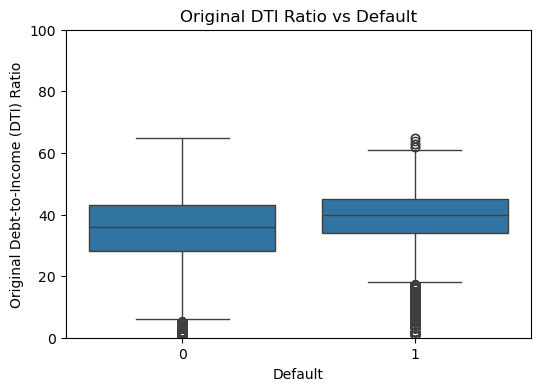

In [170]:
# Clean Original Debt-to-Income (DTI) Ratio
df1['Original Debt-to-Income (DTI) Ratio'] = pd.to_numeric(df1['Original Debt-to-Income (DTI) Ratio'], errors='coerce')
df1['Original Debt-to-Income (DTI) Ratio'] = df1['Original Debt-to-Income (DTI) Ratio'].apply(
    lambda x: 999 if pd.isna(x) else x
)

# Original DTI Ratio vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Original Debt-to-Income (DTI) Ratio', data= df1)
plt.title('Original DTI Ratio vs Default')
plt.ylim(0, 100)
plt.show()

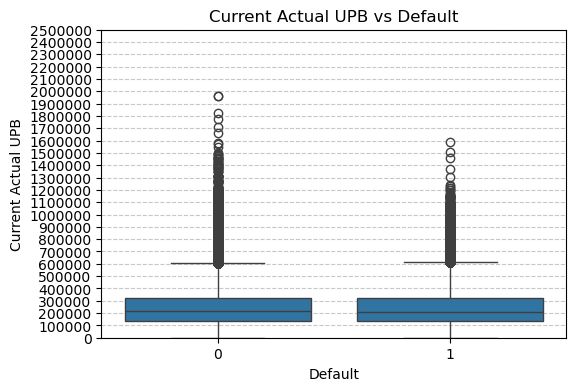

In [171]:
# Clean Current Actual UPB
df1['Current Actual UPB'] = pd.to_numeric(df1['Current Actual UPB'], errors='coerce')
df1['Current Actual UPB'] = df1['Current Actual UPB'].apply(
    lambda x: 0 if x == 0 or pd.isna(x) else x
)

# Current Actual UPB vs Default
plt.figure(figsize=(6, 4))
sns.boxplot(x='Default', y='Current Actual UPB', data= df1[df1['Current Actual UPB'] != 0])  # Exclude zero balance (000000)
plt.title('Current Actual UPB vs Default')
plt.ylim(0, 2500000)  # Reasonable upper limit in $1,000s

plt.yticks(range(0, 2500001, 100000), [str(i) for i in range(0, 2500001, 100000)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

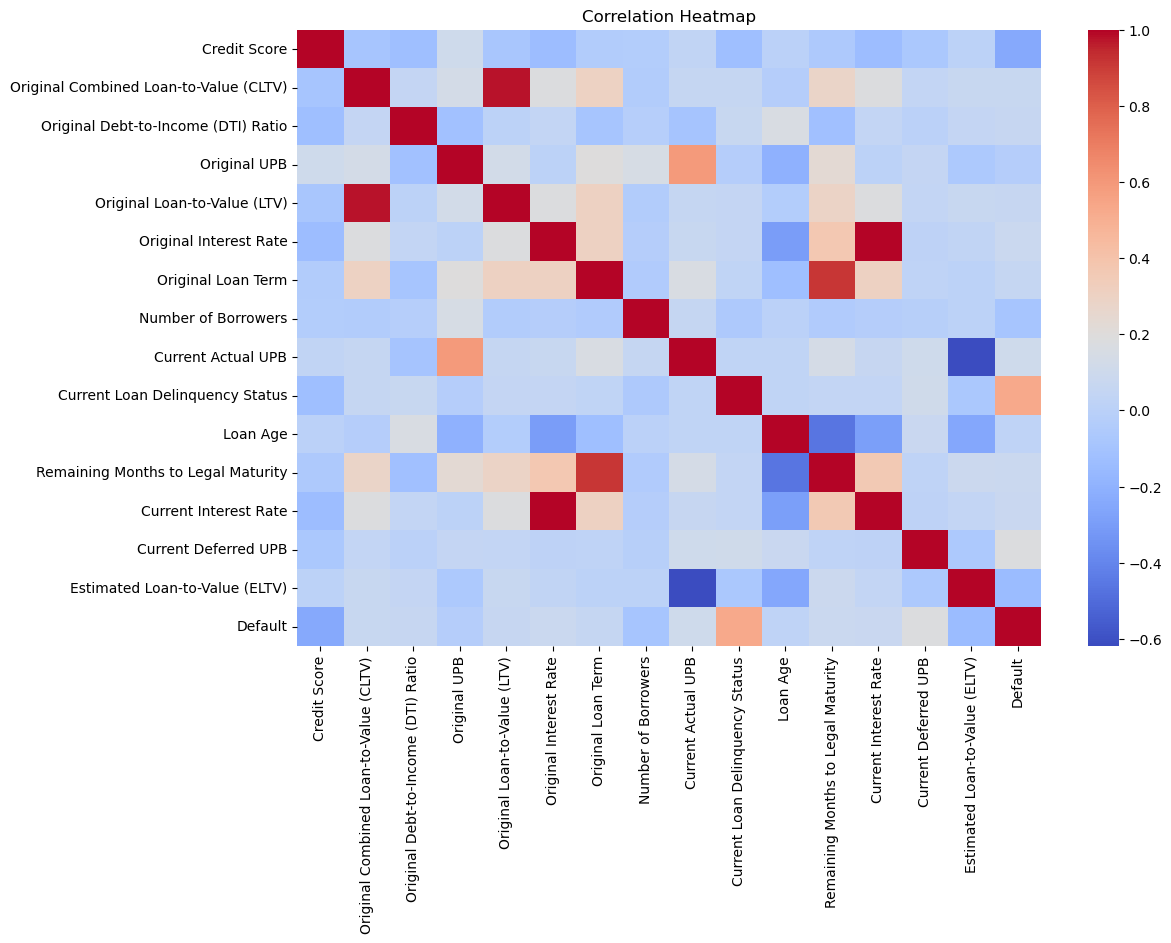

In [172]:
# Checking the correlations

numeric_cols = df1.select_dtypes(include=np.number).columns

plt.figure(figsize=(12, 8))
corr = df1[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [174]:
parquet_path = "enriched_sample_3M.parquet"
id_col = "Loan Sequence Number"
target_col = "Default"
test_size = 0.20
random_state = 42

In [175]:
df2 = pd.read_parquet(parquet_path)

In [176]:
df2= df2.drop(columns=["Current Loan Delinquency Status"])

In [177]:
if id_col in df2.columns:
    df2 = df2.drop(columns=[id_col])

In [178]:
# Define X, y
X = df2.drop(columns=[target_col])
y = df2[target_col].astype(int)

In [179]:
# Train-test split (stratified to preserve default rate)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [180]:
# Identify numeric & categorical columns (based on train set)
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

In [181]:
# Impute using TRAIN stats (median for numeric, mode for categorical)
num_medians = X_train[numeric_cols].median()
cat_modes = {col: X_train[col].mode()[0] if not X_train[col].mode().empty else "" for col in categorical_cols}

In [182]:
# Fill train
X_train[numeric_cols] = X_train[numeric_cols].fillna(num_medians)
for col in categorical_cols:
    X_train[col] = X_train[col].fillna(cat_modes[col])

In [183]:
# Fill test using train statistics
X_test[numeric_cols] = X_test[numeric_cols].fillna(num_medians)
for col in categorical_cols:
    X_test[col] = X_test[col].fillna(cat_modes[col])

In [184]:
# One-hot encode categoricals (fit on train, align test)
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)

In [185]:
# Align test columns to train (add missing cols to test as 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [186]:
# Scale numeric features (fit scaler on train numeric cols only)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [187]:
# Fit logistic regression with balanced class weights
model = LogisticRegression(class_weight="balanced", solver="saga", max_iter=1000, n_jobs=-1, random_state=random_state)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42, solver='saga')

In [188]:
y_predict= model.predict(X_test)

In [189]:
training_accuracy= model.score(X_train, y_train)
test_accuracy= model.score(X_test, y_test)
print(f"Training accuracy: {round(training_accuracy, 3)}")
print(f"Test accuracy: {round(test_accuracy, 3)}")

Training accuracy: 0.764
Test accuracy: 0.765


Text(0.5, 1.0, 'Logistic Regression ROC Curve')

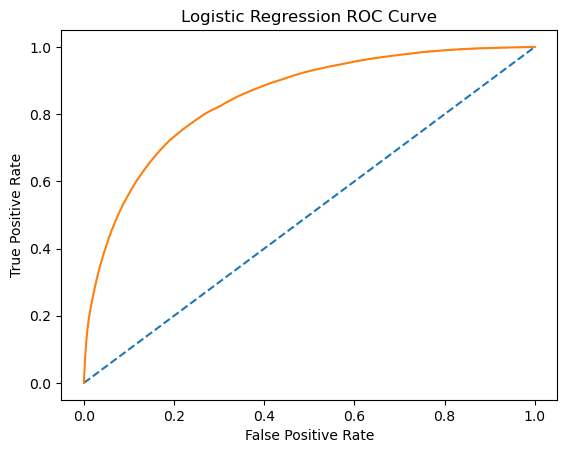

In [190]:
pred_probs= model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, pred_probs)

plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')

In [191]:
auc_score= roc_auc_score(y_test, pred_probs)
print(f"AUC score: {round(auc_score, 3)}")

AUC score: 0.847


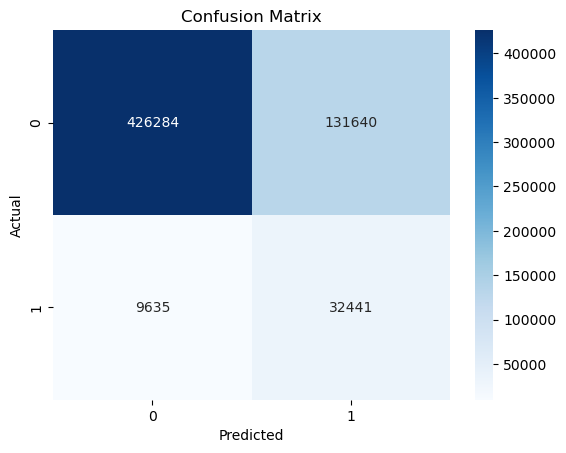

In [192]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [193]:
print("Classification report:")
print(classification_report(y_test, y_predict))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86    557924
           1       0.20      0.77      0.31     42076

    accuracy                           0.76    600000
   macro avg       0.59      0.77      0.59    600000
weighted avg       0.92      0.76      0.82    600000



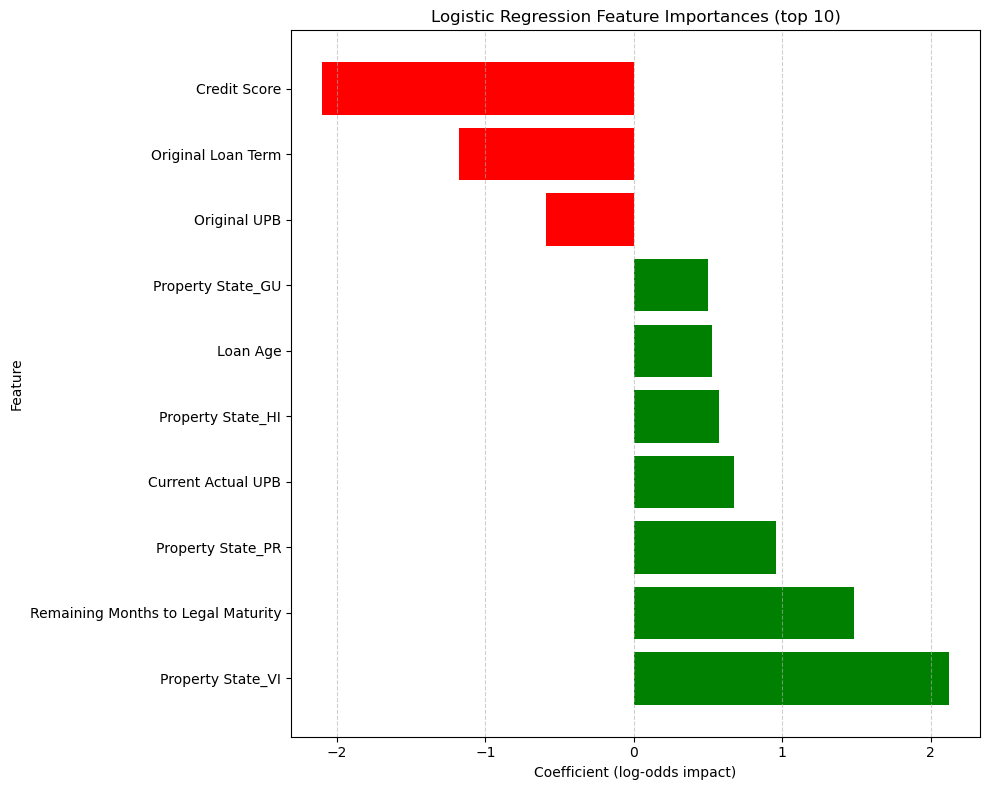

In [194]:
# Build importance DataFrame from fitted model and feature names
feat_names = X_train.columns.tolist()
coefs = model.coef_.ravel()   # shape (n_features,)

feat_imp = pd.DataFrame({
    "feature": feat_names,
    "coefficient": coefs
})

# Select top features by absolute coefficient (change top_n if you want more/less)
top_n = 10
feat_imp["abs_coef"] = feat_imp["coefficient"].abs()
top_feats = feat_imp.sort_values("abs_coef", ascending=False).head(top_n)

# Sort for plotting (so positives at top after inverting y)
top_feats = top_feats.sort_values("coefficient", ascending=True)  # ascending so largest positive at top after invert

# Plot
colors = top_feats["coefficient"].apply(lambda x: "green" if x > 0 else "red")

plt.figure(figsize=(10, 8))
plt.barh(top_feats["feature"], top_feats["coefficient"], color=colors)
plt.title("Logistic Regression Feature Importances (top {})".format(top_n))
plt.xlabel("Coefficient (log-odds impact)")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()